**Эксперимент 1**

In [2]:
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import transforms

import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

import tqdm
import os

import os

from torchsummary import summary
import seaborn as sns
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
#Подключение GPU
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda', index=0)

In [4]:
from fastai.vision import *

import warnings
warnings.filterwarnings("ignore") # Могут вылезать навязчивые ворнинги, не показываем их

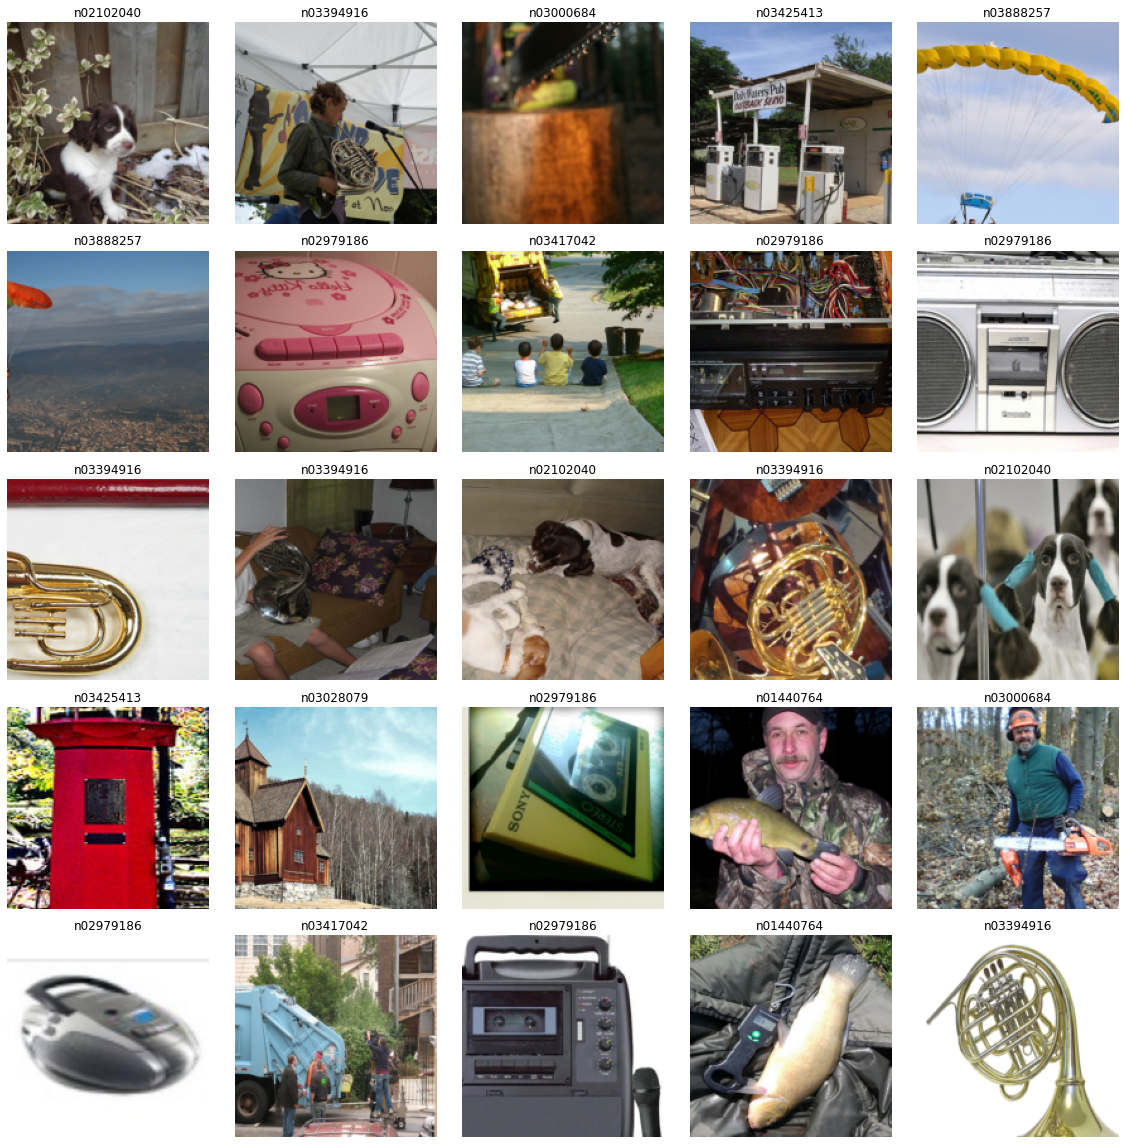

In [5]:
path = URLs.IMAGENETTE
path = untar_data(path)

batch=64
data = (ImageList.from_folder(path).split_by_folder(valid='val').label_from_folder().transform(([flip_lr(p=0.5)], []), size=160).databunch(bs=batch, num_workers=1).presize(160, scale=(0.35,1)).normalize(imagenet_stats))

data

data.show_batch(5, figsize=(16,16))

In [6]:
#  Маленькая модель - distilled model

distilledModelSequential = nn.Sequential(
    
   nn.Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1)),
   nn.ReLU(), 
   nn.BatchNorm2d(32),
   nn.MaxPool2d(kernel_size=(2,2), stride = (2,2)),
   nn.Dropout(0.25),

   nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding= 0),
   nn.ReLU(),
   nn.MaxPool2d(kernel_size=(2,2), stride = (2,2)),
   nn.BatchNorm2d(64),
   nn.Dropout(0.25),

   nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding= 0),
   nn.ReLU(),
   nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
   nn.Dropout(0.25),

   nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding= 0),
   nn.ReLU(),
   nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
   nn.BatchNorm2d(256),
   nn.Dropout(0.25),

   nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding= 0),
   nn.ReLU(),
   nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
   nn.BatchNorm2d(512),
   nn.Dropout(0.25),

   nn.Flatten(),

   nn.Linear(in_features = 4608, out_features=512),
   nn.ReLU(),
   nn.BatchNorm1d(512),
   nn.Dropout(0.5),

   nn.Linear(in_features = 512,out_features=128),
   nn.ReLU(),
   nn.BatchNorm1d(128),
   nn.Dropout(0.5),

   nn.Linear(in_features = 128,out_features=10)
)

In [7]:
def init_weights(m): # случайная инициализация весов
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)
        
distilledModelSequential.apply(init_weights)
distilledModelLearn = (Learner(data, distilledModelSequential, metrics=[accuracy])) # создание модели Learner с помощью fastai

In [7]:
distilledModelLearn.fit_one_cycle(30, 5e-3) # непосредственное обучение на 30 эпохах

epoch,train_loss,valid_loss,accuracy,time
0,2.279127,2.284642,0.163567,01:49
1,2.103961,2.430865,0.126115,01:46
2,1.696218,1.799320,0.368408,01:45
3,1.491573,1.442917,0.512611,01:45
4,1.373124,1.323010,0.551847,01:46
5,1.290665,1.380359,0.535287,01:46
6,1.203500,1.234636,0.607643,01:44
7,1.165428,1.066849,0.656306,01:45
8,1.099956,1.159088,0.621147,01:44
9,1.035429,1.222911,0.627516,01:45


Как мы видим, точность достигла значения 84.3%.

Теперь потренируем модель Le-Net5.


In [8]:
class Le_Net5(nn.Module):
    def __init__(self):
        super(Le_Net5, self).__init__()

        # Список слоев использующихся
        self.conv1 = nn.Conv2d(3, 6, kernel_size=(5, 5))
        self.conv2 = nn.Conv2d(6, 16, kernel_size=(5, 5))
        self.conv3 = nn.Conv2d(16, 120, kernel_size=(5, 5))

        self.relu = nn.ReLU()

        self.max_pool = nn.MaxPool2d(kernel_size=(4, 4), stride=4)

        self.linear = nn.Linear(1920, 84)
        self.out = nn.Linear(84, 10)
      
    
  
    def Conv1(self, inp):

        t = self.conv1(inp)
        t = self.relu(t)
        t = self.max_pool(t)

        return t

    def Conv2(self, inp):

        t = self.conv2(inp)
        t = self.relu(t)
        t = self.max_pool(t)

        return t

    def Conv3(self, inp):

        t = self.conv3(inp)
        t = self.relu(t)

        return t
    
    def Linear(self, inp):

      t = self.linear(inp)
      t = self.relu(t)

      return t

    def output(self, inp):

      t = self.out(inp)
      
      return t

    def forward(self, input):

        out = self.Conv1(input)

        x = self.Conv2(out)
        out = self.Conv2(out)

        out += x

        out = self.Conv3(out)

        out = out.view(input.size(0), -1)

        out = self.Linear(out)

        output = self.output(out)

        return output      

In [9]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)

distilled_model = Le_Net5()

        
distilled_model.apply(init_weights)
distilledModelLearnLeNet = (Learner(data, distilled_model, metrics=[accuracy])) # создание модели с помощью fastai

In [10]:
distilledModelLearnLeNet.fit_one_cycle(30, 5e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.044443,1.944817,0.330955,01:41
1,1.776826,1.683956,0.442038,01:40
2,1.638032,1.523743,0.481019,01:44
3,1.573912,1.549947,0.481274,01:42
4,1.465672,1.501707,0.495287,01:43
5,1.462210,1.340681,0.556688,01:43
6,1.457838,1.349434,0.562038,01:42
7,1.429971,1.458818,0.528917,01:37
8,1.385299,1.333790,0.546242,01:41
9,1.395408,1.201865,0.608408,01:47


Для данной модели качество составило 72%. Меньше чем для ранее расмотренной модели - из за того, что эта более маленькая и имеет меньше параметров.

**Эксперимент 2**

Теперь попробуем подсоединить к обучению большую модель и использовать ее выходы как лэйблы для маленькой

In [8]:
from fastai.vision import *

import torch
from torch import nn
from torch.nn import functional as F
from torchvision import transforms

import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

import tqdm
import os

import os

from torchsummary import summary
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore") # Могут вылезать навязчивые ворнинги, не показываем их


In [9]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda', index=0)

In [13]:
path = URLs.IMAGEWOOF 
path = untar_data(path)

batch=64
data = (ImageList.from_folder(path).split_by_folder(valid='val').label_from_folder().transform(([flip_lr(p=0.5)], []), size=160).databunch(bs=batch, num_workers=1).presize(160, scale=(0.35,1)).normalize(imagenet_stats))

In [10]:
bigModel = (cnn_learner(data, models.resnet50, metrics=[accuracy], pretrained=True, callback_fns=[ShowGraph])) # тут предобученная берется

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


epoch,train_loss,valid_loss,accuracy,time
0,0.131039,0.065731,0.980637,01:35
1,0.223982,0.203293,0.940637,01:36
2,0.313760,0.838741,0.817070,01:35
3,0.367068,0.410901,0.883312,01:35
4,0.371814,0.478448,0.853758,01:36
5,0.348336,0.272835,0.912866,01:36
6,0.288182,0.274876,0.917962,01:36
7,0.250353,0.206297,0.936306,01:36
8,0.206100,0.176593,0.946242,01:35
9,0.154126,0.200804,0.939618,01:35


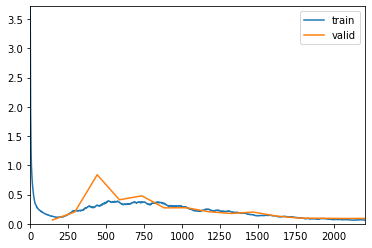

In [11]:
bigModel.fit_one_cycle(15,max_lr=1e-2) 

Достоверность большой модели составило 97%.

Я пробовал разные функции потерь для данного датасета, потому что на KL дивергенции улучшения качества не происходило, только ухудшения.

При использовании обычной Кроссэнтропии между ответами большой модели и маленькой качество было значительно выше, чем с KL дивергенцией.

In [16]:
class DistillingTheKnowledge(LearnerCallback):
    def __init__(self, distilledModel:Learner, bigModel:Learner, T:float=3.0, alfa:float=0.8):
        super().__init__(distilledModel)
        self.bigModel = bigModel
        self.T, self.alfa = T, alfa
    
    def on_backward_begin(self, last_input, last_output, last_target, **kwargs):
        bigModelOutput = self.bigModel.model(last_input)
        loss = DistillingLoss(last_output, last_target, bigModelOutput, self.T, self.alfa)


        
        return {'last_loss': loss}

# Вот разные лоссы которые я тестировал: 


# Кроссэнтропия ответов большой модели и маленькой

def DistillingLoss(output, true_labels, big_model_logit, T, alpha):
    return F.cross_entropy(F.log_softmax(output/T, dim=-1), torch.max(F.softmax(big_model_logit/T, dim=-1), 1).indices.detach()) * (T*T *2.0* alpha) + F.cross_entropy(output, true_labels) * (1.0 - alpha) 

'''
# KL дивергенция ответов большой модели и маленькой

def DistillingLoss(output, true_labels, big_model_logit, T, alpha):
    return nn.KLDivLoss(reduction='batchmean')(F.log_softmax(output/T, dim=-1), F.softmax(big_model_logit/T, dim=-1).detach()) * (T*T * 2.0 * alpha) + F.cross_entropy(output, true_labels) * (1.0 - alpha) 

'''
    

In [13]:
#  Маленькая модель - аналогичная первоначальной использующейся в первом эксперименте (мною сконструированная, не Le-Net5). 

distilledModelSequential = nn.Sequential(
    
   nn.Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1)),
   nn.ReLU(), 
   nn.BatchNorm2d(32),
   nn.MaxPool2d(kernel_size=(2,2), stride = (2,2)),
   nn.Dropout(0.25),

   nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding= 0),
   nn.ReLU(),
   nn.MaxPool2d(kernel_size=(2,2), stride = (2,2)),
   nn.BatchNorm2d(64),
   nn.Dropout(0.25),

   nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding= 0),
   nn.ReLU(),
   nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
   nn.Dropout(0.25),

   nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding= 0),
   nn.ReLU(),
   nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
   nn.BatchNorm2d(256),
   nn.Dropout(0.25),

   nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding= 0),
   nn.ReLU(),
   nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
   nn.BatchNorm2d(512),
   nn.Dropout(0.25),

   nn.Flatten(),

   nn.Linear(in_features = 4608, out_features=512),
   nn.ReLU(),
   nn.BatchNorm1d(512),
   nn.Dropout(0.5),

   nn.Linear(in_features = 512,out_features=128),
   nn.ReLU(),
   nn.BatchNorm1d(128),
   nn.Dropout(0.5),

   nn.Linear(in_features = 128,out_features=10)
)

In [14]:
# Инициализация рандомных весов

def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)
        
distilledModelSequential.apply(init_weights)
distilledModelLearn = (Learner(data, distilledModelSequential, metrics=[accuracy])) # создание модели с помощью fastai

In [17]:
# Здесь происходят эксперименты с разными значениями температуры и параметра альфа. (3.0, 0.2)

for T in [3.0, 10.0]:
  for alfa in [0.5]:
    distilledModelSequential.apply(init_weights)
    distilledModelLearn = (Learner(data, distilledModelSequential, metrics=[accuracy]))
    distilledModelLearn.model = distilledModelLearn.model.cuda()
    distilledModelLearn.fit_one_cycle(30, 5e-3, callbacks=[DistillingTheKnowledge(distilledModelLearn, bigModel=bigModel, T = T, alfa = alfa)])

epoch,train_loss,valid_loss,accuracy,time
0,2.285717,2.291156,0.125350,01:35
1,2.091316,2.183620,0.224713,01:33
2,1.808930,2.253522,0.367898,01:33
3,1.904144,2.351123,0.502420,01:32
4,1.997704,2.571335,0.533503,01:33
5,1.946144,2.228347,0.566624,01:32
6,1.889995,2.118710,0.614013,01:32
7,1.842648,2.407393,0.585223,01:32
8,1.752345,1.796299,0.634140,01:32
9,1.637640,1.628600,0.694522,01:32


epoch,train_loss,valid_loss,accuracy,time
0,2.286214,2.283722,0.162038,01:35
1,2.111053,2.291237,0.172229,01:35
2,2.377375,4.942248,0.249427,01:34
3,4.035766,5.084468,0.420637,01:33
4,5.314603,6.224387,0.498599,01:33
5,5.637457,6.319557,0.567643,01:33
6,5.910433,7.004848,0.587006,01:33
7,5.928162,6.073224,0.599490,01:33
8,5.762022,8.202276,0.606369,01:34
9,5.251853,5.661500,0.673885,01:35


Как мы видим, качество достигает 84.5%. А без использования большой модели - 84.3%. в общем разницы нету.

In [18]:
class Le_Net5(nn.Module):
    def __init__(self):
        super(Le_Net5, self).__init__()

        # Список слоев использующихся
        self.conv1 = nn.Conv2d(3, 6, kernel_size=(5, 5))
        self.conv2 = nn.Conv2d(6, 16, kernel_size=(5, 5))
        self.conv3 = nn.Conv2d(16, 120, kernel_size=(5, 5))

        self.relu = nn.ReLU()

        self.max_pool = nn.MaxPool2d(kernel_size=(4, 4), stride=4)

        self.linear = nn.Linear(1920, 84)
        self.out = nn.Linear(84, 10)
      
    
  
    def Conv1(self, inp):

        t = self.conv1(inp)
        t = self.relu(t)
        t = self.max_pool(t)
        #print(t.shape)
        return t

    def Conv2(self, inp):

        t = self.conv2(inp)
        t = self.relu(t)
        t = self.max_pool(t)
        #print(t.shape)
        return t

    def Conv3(self, inp):

        t = self.conv3(inp)
        t = self.relu(t)
        #print(t.shape)
        return t
    
    def Linear(self, inp):
      t = self.linear(inp)
      t = self.relu(t)

      return t

    def output(self, inp):

      t = self.out(inp)
      return t

    def forward(self, input):

        out = self.Conv1(input)

        x = self.Conv2(out)
        out = self.Conv2(out)

        out += x

        out = self.Conv3(out)

        out = out.view(input.size(0), -1)

        out = self.Linear(out)

        output = self.output(out)

        return output        

In [19]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)

distilled_model = Le_Net5()

        
distilled_model.apply(init_weights)
distilledModelLearnLeNet = (Learner(data, distilled_model, metrics=[accuracy])) # создание модели с помощью fastai

In [20]:
for T in [2.0, 3.0]:
  for alfa in [0.2]:
    distilled_model = Le_Net5()  
    distilled_model.apply(init_weights)
    distilledModelLearnLeNet = (Learner(data, distilled_model, metrics=[accuracy]))
    distilledModelLearnLeNet.fit_one_cycle(30, 5e-3, callbacks=[DistillingTheKnowledge(distilledModelLearnLeNet, bigModel=bigModel, T = T, alfa = alfa)])

epoch,train_loss,valid_loss,accuracy,time
0,2.055244,1.911555,0.350318,01:30
1,1.888514,1.763144,0.389299,01:29
2,1.781093,1.698533,0.430318,01:30
3,1.675442,1.567962,0.498599,01:31
4,1.617309,1.408396,0.537070,01:32
5,1.543313,1.526184,0.528662,01:33
6,1.540104,1.610647,0.519236,01:33
7,1.538202,1.621688,0.501146,01:33
8,1.505329,1.332251,0.585732,01:34
9,1.481011,1.321283,0.586497,01:34


epoch,train_loss,valid_loss,accuracy,time
0,2.141181,2.006664,0.330446,01:29
1,1.995420,2.011140,0.393376,01:29
2,1.957875,1.827694,0.458344,01:29
3,1.884050,1.815619,0.504713,01:29
4,1.879607,1.651391,0.512866,01:29
5,1.851421,1.648141,0.529172,01:29
6,1.776558,1.812726,0.551083,01:29
7,1.804803,2.685359,0.476433,01:29
8,1.768712,1.572430,0.589554,01:29
9,1.770743,1.799455,0.576306,01:30


А здесь качество достигает 71%, а вот если не использовать большую модель, то качество 72%.

**Результаты**

В данном эксперименте на датасете imagenette улучшения качества к сожалению не произошло. Я пробовал разные параметры T и alfa, также пробовал разные функции потерь, но добиться очевидного улучшения достоверности не удалось. Без помощи большой модели у маленьких моделей качество соответственно - 84.3% и 72%. А с большой моделью только - 84.5%, 71%. Такое бывает, возможно нужно больше поперебирать параметры и провести больше экспериментов и возможно тогда это заведется.